In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from stacked_generalization.lib.stacking import StackedClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from hyperopt import fmin, tpe, hp, space_eval
from sklearn.model_selection import cross_val_score
%reload_ext autoreload
%autoreload 2
from modeling import transformers
from modeling import parameter_tuning
data_dir = "data/"
output_data_dir = "output_data/"
models_dir = "models/"
%pylab inline
pd.set_option('display.max_columns', 999)
import random
import time
from sklearn.preprocessing import LabelEncoder

Populating the interactive namespace from numpy and matplotlib


/home/vlandeau/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'fmin']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Loading data

###  Independent variables

In [2]:
indep_df = pd.read_csv(data_dir + "independent_variables.csv")

In [3]:
indep_df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
len(indep_df.id.drop_duplicates())/len(indep_df)

1

In [5]:
indep_df.set_index("id", inplace=True)

### Dependent variable

In [6]:
dep_df = pd.read_csv(data_dir + "dependent_variables.csv")

In [7]:
dep_df.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [8]:
dep_df.set_index("id", inplace=True)

In [9]:
len(indep_df)/float(len(dep_df))

1.0

# Preprocessing

###TODO

Missing values in construction year, populatoin

Clustering for latitude/longitude?

For categorical with many modes, add feature -> projection of mode in target space

In [10]:
indep_df.num_private.value_counts()

0       58643
6          81
1          73
5          46
8          46
32         40
45         36
15         35
39         30
93         28
3          27
7          26
2          23
65         22
47         21
102        20
4          20
17         17
80         15
20         14
25         12
11         11
41         10
34         10
16          8
120         7
150         6
22          6
12          5
24          5
        ...  
14          3
61          3
27          2
26          2
160         1
30          1
698         1
60          1
1402        1
450         1
668         1
131         1
35          1
672         1
42          1
136         1
87          1
300         1
280         1
141         1
62          1
111         1
240         1
1776        1
755         1
180         1
213         1
23          1
55          1
94          1
Name: num_private, dtype: int64

In [11]:
indep_df.dtypes

amount_tsh               float64
date_recorded             object
funder                    object
gps_height                 int64
installer                 object
longitude                float64
latitude                 float64
wpt_name                  object
num_private                int64
basin                     object
subvillage                object
region                    object
region_code                int64
district_code              int64
lga                       object
ward                      object
population                 int64
public_meeting            object
recorded_by               object
scheme_management         object
scheme_name               object
permit                    object
construction_year          int64
extraction_type           object
extraction_type_group     object
extraction_type_class     object
management                object
management_group          object
payment                   object
payment_type              object
water_qual

In [12]:
indep_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [13]:
indep_df.shape

(59400, 39)

In [14]:
preprocessing_pipeline = Pipeline([
        ("TimeStampConverter", transformers.TimeStampConverter(cols_to_convert=['date_recorded'], 
                                                               date_format="%Y-%m-%d")),
        ("TypeConverter", transformers.TypeConverter(cols_to_convert=['region_code', 
                                                                      'district_code'], final_type=object)),
        
        ("ReplaceNegativeByNan", transformers.ReplaceNegativeByNan(columns_to_transform=["population", "construction_year"])),
        ("NanIndicatorAdder", transformers.NanIndicatorAdder()),
        ("CategoricalFeatureImputer", transformers.CategoricalFeatureImputer()),
        ("DateInfoGetter", transformers.DateInfoGetter()),
        
        ("ClassifierProjectionFeature", transformers.ClassifierProjectionFeature(projection_threshold=0.1)),
        ("ImputationByMedian", transformers.NumericalFeatureImputation(strategy="mean")),
        ("RareValuesRemover", transformers.RareValuesRemover(threshold=0.1)),
        ("Dummifier", transformers.Dummifier()),
        
        ("OutlierRemoval", transformers.OutlierRemoval(anomaly_threshold=0.8)),
        ("ConvertToNp", transformers.PandasDfToNpArrayConverter()),
        ("VarianceThreshold", VarianceThreshold(threshold=0.3)),
        ("StandardScaler", StandardScaler())
    ])
df_train, df_test, y_train, y_test = train_test_split(indep_df, dep_df, test_size=0.2)
print df_train.shape
print y_train.shape
print df_test.shape
print y_test.shape
x_train = preprocessing_pipeline.fit_transform(df_train, y_train.status_group)

(47520, 39)
(47520, 1)
(11880, 39)
(11880, 1)


/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

In [15]:
outlier_mask = preprocessing_pipeline.named_steps["OutlierRemoval"].outlier_mask
print outlier_mask.sum()
y_train = y_train.loc[outlier_mask, :]
features = preprocessing_pipeline.named_steps["ConvertToNp"].features[
    preprocessing_pipeline.named_steps["VarianceThreshold"].get_support()]

47520


In [17]:
print [x for x in features if "target" in x]
print [x for x in features if "count" in x]

[]
['basin_count', 'date_recorded_month_count', 'date_recorded_year_count', 'extraction_type_class_count', 'extraction_type_count', 'extraction_type_group_count', 'funder_count', 'installer_count', 'lga_count', 'management_count', 'management_group_count', 'payment_count', 'payment_type_count', 'permit_count', 'public_meeting_count', 'quality_group_count', 'quantity_count', 'quantity_group_count', 'region_count', 'scheme_management_count', 'scheme_name_count', 'source_class_count', 'source_count', 'source_type_count', 'subvillage_count', 'ward_count', 'water_quality_count', 'waterpoint_type_count', 'waterpoint_type_group_count', 'wpt_name_count']


In [18]:
x_test = preprocessing_pipeline.transform(df_test)
outlier_mask = preprocessing_pipeline.named_steps["OutlierRemoval"].outlier_mask
print outlier_mask.sum()
y_test = y_test.loc[outlier_mask, :]

11880


In [21]:
lbl_enc = LabelEncoder()
y_train_num = lbl_enc.fit_transform(y_train)
y_test_num = lbl_enc.transform(y_test)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:125: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/preprocessing/label.py:143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
x_train.dump(output_data_dir + "train_data_with_variance_threshold.dump")
x_test.dump(output_data_dir + "test_data_without_variance_threshold.dump")
y_train_num.dump(output_data_dir + "train_target.dump")
y_test_num.dump(output_data_dir + "test_target.dump")


In [3]:
x_train1 = np.load("train_data_with_variance_threshold.dump")
x_train2 = np.load("train_data_without_variance_threshold.dump")
x_test1 = np.load("test_data_with_variance_threshold.dump")
x_test2 = np.load("test_data_without_variance_threshold.dump")
y_train = pd.read_csv("target_train_data.csv")
y_test = pd.read_csv("target_test_data.csv")
dep_df = pd.read_csv("target.csv")

# Test set

In [37]:
df_test_set = pd.read_csv("data/test_set.csv")

In [38]:
df_test_set.set_index("id", inplace=True)

In [39]:
df_test_set.shape

(14850, 39)

In [40]:
test_set = preprocessing_pipeline.transform(df_test_set)


Starting method transform of class TimeStampConverter
Method transform of class TimeStampConverter took 0.00819110870361 seconds to perform
Starting method transform of class TypeConverter
Method transform of class TypeConverter took 0.00392198562622 seconds to perform
Starting method transform of class ReplaceNegativeByNan
Method transform of class ReplaceNegativeByNan took 0.0194580554962 seconds to perform
Starting method transform of class NanIndicatorAdder
Method transform of class NanIndicatorAdder took 0.0231671333313 seconds to perform
Starting method transform of class CategoricalFeatureImputer
Method transform of class CategoricalFeatureImputer took 0.0415408611298 seconds to perform
Starting method transform of class DateInfoGetter
Method transform of class DateInfoGetter took 0.357536077499 seconds to perform
Starting method transform of class ClassifierProjectionFeature
Method transform of class ClassifierProjectionFeature took 0.446022033691 seconds to perform
Starting me

In [72]:
y_test_set_pred = sl.predict(test_set)

In [73]:
y_test_set_pred.

array([2, 0, 0, 2, 0, 0, 2, 2, 2, 0])

In [76]:
dep_df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [77]:
y_res.status_group.value_counts()

0    8724
2    5744
1     382
Name: status_group, dtype: int64

In [74]:
y_res = pd.DataFrame({"id": df_test_set.index, "status_group": y_test_set_pred})

In [79]:
y_res["status_group"].replace({0: "functional", 2: "non functional", 1: "functional needs repair"}, inplace=True)

In [80]:
y_res.head()

,id,status_group
0,50785,non functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [81]:
y_res.to_csv("data/submission.csv", index=False)

# Clustering géographique

In [27]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN()
dbs.fit(indep_df[["latitude", 'longitude']])

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
    min_samples=5, n_jobs=1, p=None)

In [37]:
xy = indep_df[class_member_mask & core_samples_mask]
xy[:3]

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe


In [41]:
dbs.core_sample_indices_

array([    0,     1,     2, ..., 59397, 59398, 59399])

In [38]:
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True
labels = dbs.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = indep_df[['latitude', 'longitude']][class_member_mask & core_samples_mask]
    plt.plot(xy.loc[:1000, 'latitude'], xy.loc[:, 'longitude'], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = indep_df[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:1000, 'latitude'], xy[:1000, 'longitude'], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

KeyError: 1000

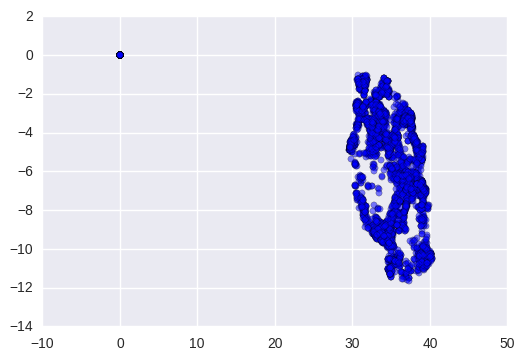

In [25]:
import matplotlib.pyplot as plt
indep_df_sample = indep_df.sample(5000)
plt.scatter(indep_df_sample.longitude, indep_df_sample.latitude, alpha=0.5)
plt.show()

# Visualization

/home/vlandeau/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


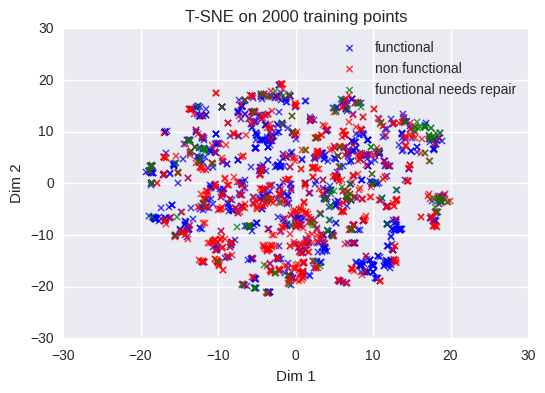

In [71]:
n_points = 2000
perplexity = 25

sample_index = random.sample(range(len(y_train)),n_points)
X_tsne = TSNE(perplexity=perplexity).fit_transform(x_train[sample_index])
y_tsne = y_train.status_group.as_matrix()[sample_index]

plt.figure()
colors = ['g', 'b', 'r']
for value in dep_df.status_group.unique():
    plt.scatter(X_tsne[np.where(y_tsne == value), 0],
                       X_tsne[np.where(y_tsne == value), 1],
                       marker='x', color=colors.pop(randint(len(colors))),
                       linewidth='1', alpha=0.8, label=value)

plt.xlabel('Dim 1')
plt.ylabel('Dim 2')
plt.title('T-SNE on %d training points' % n_points)
plt.legend(loc='best')
plt.show()

# Preprocessing parameters tuning

In [51]:
preprocessing_pipeline = Pipeline([
        ("TimeStampConverter", transformers.TimeStampConverter(cols_to_convert=['date_recorded'], date_format="%Y-%m-%d")),
        ("TypeConverter", transformers.TypeConverter(cols_to_convert=['region_code', 'district_code'], final_type=object)),
        
        ("ReplaceNegativeByNan", transformers.ReplaceNegativeByNan(columns_to_transform=["population", "construction_year"])),
        ("NanIndicatorAdder", transformers.NanIndicatorAdder()),
        ("CategoricalFeatureImputer", transformers.CategoricalFeatureImputer()),
        ("DateInfoGetter", transformers.DateInfoGetter())
  ])
df_train_raw, df_test_raw, y_train, y_test = train_test_split(indep_df, dep_df, test_size=0.2)
df_train = preprocessing_pipeline.fit_transform(df_train_raw)
df_test = preprocessing_pipeline.transform(df_test_raw)

In [56]:
reload(transformers)

<module 'transformers' from 'transformers.pyc'>

In [57]:
model_pipeline = Pipeline([
        ("ClassifierProjectionFeature", transformers.ClassifierProjectionFeature(projection_threshold=0.1)),
        ("ImputationByMedian", transformers.NumericalFeatureImputation(strategy="median")),
        ("RareValuesRemover", transformers.RareValuesRemover(threshold=0.01)),
        ("Dummifier", transformers.Dummifier()),
        ("ConvertToNp", transformers.PandasDfToNpArrayConverter()),
        ("VarianceThreshold", VarianceThreshold(threshold=0.05)),
        ("StandardScaler", StandardScaler())])


In [58]:
lbl_enc = LabelEncoder()
y_train_num = lbl_enc.fit_transform(y_train.status_group)
y_test_num = lbl_enc.transform(y_test.status_group)

In [69]:
space_pipeline = {
    "ClassifierProjectionFeature__projection_threshold": hp.quniform(
        'ClassifierProjectionFeature__projection_threshold', 0, 0.2, 0.001),
    "ImputationByMedian__strategy": hp.choice(
        'ImputationByMedian__strategy', ["mean", "median"]),
    "RareValuesRemover__threshold": hp.quniform(
        'RareValuesRemover__threshold', 0.001, 0.3, 0.001),
    "VarianceThreshold__threshold": hp.quniform(
        'VarianceThreshold__threshold', 0.001, 0.3, 0.001)}

tuner = parameter_tuning.ParameterTuner(df_train, y_train_num)
best, trials = tuner.tune_pipeline_parameters(model_pipeline, space_pipeline, max_evals=100)

Iteration 0: score 0.724410810829 with std 0.00141287037186 for params {'VarianceThreshold__threshold': 0.145, 'rf__max_depth': 9, 'rf__n_estimators': 138, 'rf__bootstrap': True, 'rf__criterion': 'gini', 'RareValuesRemover__threshold': 0.296, 'ClassifierProjectionFeature__projection_threshold': 0.048, 'ImputationByMedian__strategy': 'mean', 'rf__max_features': 'sqrt', 'rf__n_jobs': 4}
Iteration 1: score 0.646885495968 with std 0.00696577284168 for params {'VarianceThreshold__threshold': 0.099, 'rf__max_depth': None, 'rf__n_estimators': 758, 'rf__bootstrap': False, 'rf__criterion': 'entropy', 'RareValuesRemover__threshold': 0.025, 'ClassifierProjectionFeature__projection_threshold': 0.10400000000000001, 'ImputationByMedian__strategy': 'median', 'rf__max_features': None, 'rf__n_jobs': 4}
Iteration 2: score 0.686721549577 with std 0.00388970754037 for params {'VarianceThreshold__threshold': 0.299, 'rf__max_depth': 2, 'rf__n_estimators': 671, 'rf__bootstrap': False, 'rf__criterion': 'entro

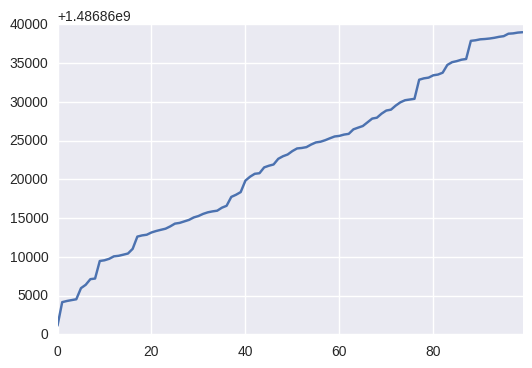

In [79]:
pd.Series(map(lambda x: x["eval_time"], trials.results)).plot()

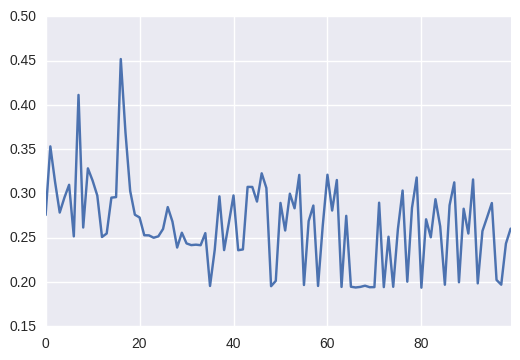

In [74]:
pd.Series(trials.losses()).plot()

In [70]:
best

{'ClassifierProjectionFeature__projection_threshold': 0.078,
 'ImputationByMedian__strategy': 'median',
 'RareValuesRemover__threshold': 0.018000000000000002,
 'VarianceThreshold__threshold': 0.276,
 'rf__bootstrap': True,
 'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 329,
 'rf__n_jobs': 4}

In [26]:
best

{'ClassifierProjectionFeature__projection_threshold': 0.019,
 'ImputationByMedian__strategy': 'mean',
 'RareValuesRemover__threshold': 0.20500000000000002,
 'VarianceThreshold__threshold': 0.245,
 'rf__bootstrap': True,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__n_estimators': 957,
 'rf__n_jobs': 4}

In [24]:
best

{'ClassifierProjectionFeature__projection_threshold': 0.10300000000000001,
 'ImputationByMedian__strategy': 'mean',
 'RareValuesRemover__threshold': 0.048,
 'VarianceThreshold__threshold': 0.29,
 'rf__bootstrap': True,
 'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__n_estimators': 877,
 'rf__n_jobs': 4}

In [24]:
best

{'ClassifierProjectionFeature__projection_threshold': 0.10300000000000001,
 'ImputationByMedian__strategy': 'mean',
 'RareValuesRemover__threshold': 0.048,
 'VarianceThreshold__threshold': 0.29,
 'rf__bootstrap': True,
 'rf__criterion': 'entropy',
 'rf__max_depth': None,
 'rf__max_features': 'log2',
 'rf__n_estimators': 877,
 'rf__n_jobs': 4}

In [57]:
best

{'ClassifierProjectionFeature__projection_threshold': 0.122,
 'ImputationByMedian__strategy': 'median',
 'RareValuesRemover__threshold': 0.013000000000000001,
 'VarianceThreshold__threshold': 0.275,
 'rf__bootstrap': True,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 269,
 'rf__n_jobs': 4}

In [92]:
model_pipeline.set_params(**{'ClassifierProjectionFeature__projection_threshold': 0.078,
 'ImputationByMedian__strategy': 'median',
 'RareValuesRemover__threshold': 0.018,
 'VarianceThreshold__threshold': 0.276,})
x_train = model_pipeline.fit_transform(df_train, y_train.status_group)
x_test = model_pipeline.fit_transform(df_test, y_test.status_group)

In [ ]:
tuner.x_train = x_train
tuner.y_train = y_train_num

In [ ]:
space_gbm = {
      "max_depth": hp.choice("max_depth", range(2, 8, 1) + [None]),
      #"loss": ["ls", "lad", "huber", "quantile"],
      "max_features": hp.choice("max_features", ["auto", "sqrt", "log2", None]),
      "min_samples_split": hp.choice("min_samples_split", range(1, 11)),
      "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 11)),
      "n_estimators": hp.choice("n_estimators", range(50, 500, 5))}

tuner.tune_model_parameters(GradientBoostingClassifier(), space=space_gbm, 
                            cv=5, max_evals=50)

In [48]:
from sklearn.preprocessing import LabelEncoder
y_train_num = LabelEncoder().fit_transform(y_train.status_group)

In [87]:
space = {"C": 3}
svc = SVC()
estimator = svc.set_params(**space)
estimator.fit(x_train, y_train_num)
s = estimator.score(x_train, y_train_num)
scores = cross_val_score(estimator, x_train, y_train_num, cv=3)
print "Iteration %s: score %s with std %s for params %s" % (objective.current_iteration,
                                                            scores.mean(), 
                                                            scores.std(), 
                                                           str(space))

AttributeError: 'function' object has no attribute 'current_iteration'

In [49]:
from hyperopt import fmin
space_svc = {
    "C": hp.quniform("C", 0.1, 1, 0.1)
}
svc = SVC()
def objective_svc(space):
    estimator = svc.set_params(**space)
    scores = cross_val_score(estimator, x_train, y_train_num, cv=3)
    print "Iteration %s: score %s with std %s for params %s" % (objective.current_iteration,
                                                                scores.mean(), 
                                                                scores.std(), 
                                                               str(space))
    return - scores.mean()
    
objective_svc.current_iteration = 0

best_svc = fmin(fn=objective_svc, space=space_svc, 
            algo=tpe.suggest, max_evals=2)

#tuner.tune_model_parameters(SVC(), space=space_svc, cv=5, max_evals=15)

ValueError: could not convert string to float: communal standpipe

# Stacking

In [51]:
y_train_array = y_train.status_group.as_matrix()
y_test_array = y_test.status_group.as_matrix()

In [52]:
from stacked_generalization.lib.stacking import StackedClassifier
clfs = [
    SVC(C=1, gamma=0.125),
    GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=7, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=9, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=195),
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=19, p=1, weights='distance'),
    RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=4)
]
bclf = LogisticRegression(random_state=1)
sl = StackedClassifier(bclf, clfs, verbose=1)

sl.fit(x_train, y_train_array)


Training classifier [0]
Fold [0]
Fold [1]
Fold [2]
Training classifier [1]
Fold [0]
Fold [1]
Fold [2]
Training classifier [2]
Fold [0]
Fold [1]
Fold [2]
Training classifier [3]
Fold [0]
Fold [1]
Fold [2]


StackedClassifier(Kfold=None,
         bclf=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
         clfs=[SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.125, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance'... n_jobs=4,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)],
         n_folds=3,
         oob_metrics=<function accuracy_score at 0x7f355947f848>,
         oob_score_flag=False, save_dir='', save_stage0=False,
         stack_by_proba=True, verbose=1)

In [53]:
y_test_pred = sl.predict(x_test)

In [54]:
y_test_pred

array([2, 2, 2, ..., 2, 0, 2])

In [55]:
y_test_array_num = y_test_array
y_test_array_num[y_test_array_num == 'functional needs repair'] = 1
y_test_array_num[y_test_array_num == 'functional'] = 0
y_test_array_num[y_test_array_num == 'non functional'] = 2
y_test_array_num.dtype = int

TypeError: Cannot change data-type for object array.

In [56]:
(y_test_array_num - y_test_pred).sum()/float(len(y_test_array_num))

0.05446127946127946

In [56]:
y_test_array_num.astype(int)

array([1, 0, 0, ..., 2, 2, 2])

In [57]:
print confusion_matrix(y_true=y_test_array_num.astype(int), y_pred=y_test_pred)


[[5621   60  725]
 [ 503  202  174]
 [ 899   30 3666]]


In [58]:
#print confusion_matrix(y_true=pd.Series(y_test_array_num), y_pred=pd.Series(y_test_pred))
print sl.score(x_test, y_test_array_num.astype(int))

print "elapsed time: " + str(time.time() - start_time)

0.798737373737
elapsed time: 99121.4748001


In [47]:
sl.bclf.coef_

array([[  1.21838949,   1.12615126,   1.05890916,  -0.93002628,
         -0.83562258,   2.05482284,   2.71790006, -10.44732172,
        -11.42188503],
       [ -1.22053363,  -1.15375846,  -0.73616353,   1.70492116,
          1.85970783,  -1.54352323,  -1.14687455,   9.13982316,
         -0.88611353],
       [ -1.19534916,  -0.90828319,  -1.14712865,   0.2585211 ,
          0.60797439,  -0.60305805,  -1.49654993,   1.04057034,   9.5691332 ]])

In [45]:
bclf.coef_


array([[  1.21838949,   1.12615126,   1.05890916,  -0.93002628,
         -0.83562258,   2.05482284,   2.71790006, -10.44732172,
        -11.42188503],
       [ -1.22053363,  -1.15375846,  -0.73616353,   1.70492116,
          1.85970783,  -1.54352323,  -1.14687455,   9.13982316,
         -0.88611353],
       [ -1.19534916,  -0.90828319,  -1.14712865,   0.2585211 ,
          0.60797439,  -0.60305805,  -1.49654993,   1.04057034,   9.5691332 ]])

# Model fitting

In [72]:

start_time = time.time()

gbm = GradientBoostingClassifier(learning_rate=0.1, loss='deviance',
              max_depth=None, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=7, min_samples_split=4,
              min_weight_fraction_leaf=0.0, n_estimators=350)

gbm.fit(x_train, y_train.status_group)

y_test_pred = gbm.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred1)

print "elapsed time: " + str(time.time() - start_time)

NameError: name 'x_train1' is not defined

In [ ]:
gbm.score(x_test1, y_test)

In [ ]:
importances = pd.DataFrame({"features": features, "importance": rf1.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

In [20]:
start_time = time.time()

rf = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=450,
                            n_jobs=4)

rf.fit(x_train, y_train.status_group)

y_test_pred = rf.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5487  112  880]
 [ 499  171  142]
 [1437   46 3106]]
elapsed time: 22.810213089


In [30]:
start_time = time.time()

rf = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=450,
                            n_jobs=4)

rf.fit(x_train, y_train.status_group)

y_test_pred = rf.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5481  140  899]
 [ 514  187  159]
 [1400   31 3069]]
elapsed time: 22.5567569733


In [31]:
rf.score(x_test, y_test)

0.73543771043771045

In [21]:
rf.score(x_test, y_test)

0.73771043771043776

In [65]:
rf1.score(x_test1, y_test)

0.77171717171717169

In [66]:
importances = pd.DataFrame({"features": features, "importance": rf1.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

,features,importance
2,longitude,0.070970
3,latitude,0.069277
89,quantity_group_dry,0.061086
85,quantity_dry,0.058218
8,construction_year,0.044986
113,date_recorded_since_beginning,0.044266
1,gps_height,0.039465
7,population,0.029384
110,date_recorded_weekday,0.024789
109,waterpoint_type_group_other,0.021701


In [25]:
start_time = time.time()

rf2 = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=300,
                            n_jobs=4)

rf2.fit(x_train, y_train.status_group)

y_test_pred = rf2.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5400  126  910]
 [ 534  195  169]
 [1407   33 3106]]
elapsed time: 17.1001861095


In [26]:
rf2.score(x_test, y_test)

0.7324074074074074

In [16]:
y_train.status_group.unique()

array(['functional', 'non functional', 'functional needs repair'], dtype=object)

In [24]:
dict_replace = {
    'functional': 1,
    'non functional': 0,
    'functional needs repair': -1
}
y_array = y_train.status_group.replace(dict_replace).as_matrix()
y_array_test = y_test.status_group.replace(dict_replace).as_matrix()

In [30]:
from sklearn.neighbors import KNeighborsClassifier

start_time = time.time()

knn = KNeighborsClassifier(n_neighbors=60, n_jobs=4)

knn.fit(x_train, y_train.status_group)

y_test_pred = knn.predict(x_test)
print confusion_matrix(y_true=y_test.status_group, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[5682   54  700]
 [ 604  118  176]
 [1622   38 2886]]
elapsed time: 85.210547924


In [31]:
print knn.score(x_test, y_test.status_group)

0.731144781145


In [35]:
print knn.score(x_test, y_test.status_group)

0.717845117845


In [ ]:
start_time = time.time()

rf2 = RandomForestClassifier(bootstrap=True, criterion='gini',
                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                            min_samples_leaf=2, min_samples_split=5,
                            min_weight_fraction_leaf=0.0, n_estimators=150,
                            n_jobs=4)

rf2.fit(x_train2, y_train.status_group)

y_test_pred2 = rf2.predict(x_test2)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred2)

print "elapsed time: " + str(time.time() - start_time)

#### TODO

Try KNN

Try stacking

In [77]:
start_time = time.time()

knn = KNeighborsClassifier(n_jobs=4)
space = {
    "n_neighbors": hp.choice(
        'n_neighbors', range(5, 150, 1)),
    'weights': hp.choice("weights", ['uniform', 'distance']),
    'p': hp.choice('p', [1, 2])
}
def objective(space):
    estimator = knn.set_params(**space)
    scores = cross_val_score(estimator, x_train, y_train.status_group, cv=3)
    print "Iteration %s: score %s with std %s for params %s" % (objective.current_iteration,
                                                                scores.mean(), 
                                                                scores.std(), 
                                                               str(space))
    objective.current_iteration += 1
    return - scores.mean()
    
objective.current_iteration = 0

best = fmin(fn=objective, space=space, 
            algo=tpe.suggest, max_evals=25)

Iteration 0: score 0.721233271848 with std 0.00337522457862 for params {'n_neighbors': 74, 'weights': 'uniform', 'p': 1}
Iteration 1: score 0.748358764537 with std 0.00380215973563 for params {'n_neighbors': 57, 'weights': 'distance', 'p': 2}
Iteration 2: score 0.745686179036 with std 0.00355290836726 for params {'n_neighbors': 77, 'weights': 'distance', 'p': 2}
Iteration 3: score 0.755450390517 with std 0.00205557802266 for params {'n_neighbors': 24, 'weights': 'distance', 'p': 2}
Iteration 4: score 0.768644877511 with std 0.00190056559125 for params {'n_neighbors': 39, 'weights': 'distance', 'p': 1}
Iteration 5: score 0.763152532963 with std 0.00373155624605 for params {'n_neighbors': 75, 'weights': 'distance', 'p': 1}
Iteration 6: score 0.708585961434 with std 0.00226466802929 for params {'n_neighbors': 57, 'weights': 'uniform', 'p': 2}
Iteration 7: score 0.690530300881 with std 0.000938377258209 for params {'n_neighbors': 125, 'weights': 'uniform', 'p': 2}
Iteration 8: score 0.7413

In [48]:
space_eval({
    "n_neighbors": hp.choice(
        'n_neighbors', range(5, 150, 1)),
    'weights': hp.choice("weights", ['uniform', 'distance']),
    'p': hp.choice('p', [1, 2])
}, {'n_neighbors': 14, 'p': 0, 'weights': 1})

{'n_neighbors': 19, 'p': 1, 'weights': 'distance'}

In [78]:
best

{'n_neighbors': 14, 'p': 0, 'weights': 1}

In [79]:
start_time = time.time()

gbm = GradientBoostingClassifier()
space_gbm = {
      "max_depth": hp.choice("max_depth", range(2, 8, 1) + [None]),
      #"loss": ["ls", "lad", "huber", "quantile"],
      "max_features": hp.choice("max_features", ["auto", "sqrt", "log2", None]),
      "min_samples_split": hp.choice("min_samples_split", range(1, 11)),
      "min_samples_leaf": hp.choice("min_samples_leaf", range(1, 11)),
      "n_estimators": hp.choice("n_estimators", range(50, 500, 5))}
def objective_gbm(space):
    estimator = gbm.set_params(**space)
    scores = cross_val_score(estimator, x_train, y_train.status_group, cv=3)
    print "Iteration %s: score %s with std %s for params %s" % (objective.current_iteration,
                                                                scores.mean(), 
                                                                scores.std(), 
                                                               str(space))
    objective.current_iteration += 1
    return - scores.mean()
    
objective.current_iteration = 0

best_gbm = fmin(fn=objective_gbm, space=space_gbm, 
            algo=tpe.suggest, max_evals=25)

Iteration 0: score 0.746422388199 with std 0.00338198916354 for params {'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 80, 'max_depth': 3, 'min_samples_leaf': 1}
Iteration 1: score 0.797748183113 with std 0.00328497731558 for params {'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 255, 'max_depth': 6, 'min_samples_leaf': 7}
Iteration 2: score 0.792697628889 with std 0.00355814385708 for params {'max_features': 'sqrt', 'min_samples_split': 3, 'n_estimators': 95, 'max_depth': 7, 'min_samples_leaf': 7}
Iteration 3: score 0.782091649297 with std 0.00231719151974 for params {'max_features': 'log2', 'min_samples_split': 3, 'n_estimators': 155, 'max_depth': 5, 'min_samples_leaf': 6}
Iteration 4: score 0.771443503777 with std 0.00205813271683 for params {'max_features': None, 'min_samples_split': 9, 'n_estimators': 275, 'max_depth': 3, 'min_samples_leaf': 6}
Iteration 5: score 0.79602263108 with std 0.00240539005654 for params {'max_features': 'auto', 'min_samp

In [82]:
range(50, 500, 5)[29]

195

In [46]:
space_eval(space_gbm, {'max_depth': 5,
 'max_features': 0,
 'min_samples_leaf': 8,
 'min_samples_split': 7,
 'n_estimators': 29})

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 9,
 'min_samples_split': 8,
 'n_estimators': 195}

In [80]:
best_gbm

{'max_depth': 5,
 'max_features': 0,
 'min_samples_leaf': 8,
 'min_samples_split': 7,
 'n_estimators': 29}

In [41]:
start_time = time.time()

svc = SVC()

space_svc = {
    "C": hp.choice("C", [2**x for x in range(-5, 8, 1)]),
    "gamma": hp.choice("gamma", [2**x for x in range(-5, 8, 1)])
}

def objective_svc(space):
    estimator = svc.set_params(**space)
    scores = cross_val_score(estimator, x_train, y_train.status_group, cv=3)
    print "Iteration %s: score %s with std %s for params %s" % (objective.current_iteration,
                                                                scores.mean(), 
                                                                scores.std(), 
                                                               str(space))
    objective.current_iteration += 1
    return - scores.mean()
    
objective_svc.current_iteration = 0

best_svc = fmin(fn=objective_svc, space=space_svc, 
            algo=tpe.suggest, max_evals=12)

print "elapsed time: " + str(time.time() - start_time)

Iteration 0: score 0.559469709085 with std 0.000427535798603 for params {'C': 0.03125, 'gamma': 0.25}
Iteration 1: score 0.732512584371 with std 0.00176112149152 for params {'C': 8, 'gamma': 0.5}
Iteration 2: score 0.632302125138 with std 0.00230500989109 for params {'C': 128, 'gamma': 64}
Iteration 3: score 0.626641385254 with std 0.00182893959391 for params {'C': 16, 'gamma': 128}
Iteration 4: score 0.666813841987 with std 0.00324980730855 for params {'C': 0.25, 'gamma': 0.5}
Iteration 5: score 0.735669043757 with std 0.00441253784903 for params {'C': 1, 'gamma': 0.5}
Iteration 6: score 0.650862739222 with std 0.00371512630556 for params {'C': 128, 'gamma': 16}
Iteration 7: score 0.727293726481 with std 0.00168245327642 for params {'C': 32, 'gamma': 0.5}
Iteration 8: score 0.768792217124 with std 0.00262170140703 for params {'C': 1, 'gamma': 0.125}
Iteration 9: score 0.763931168442 with std 0.00405107116476 for params {'C': 2, 'gamma': 0.03125}
Iteration 10: score 0.626536162412 with

In [44]:
space_eval(space_svc, best_svc)

{'C': 1, 'gamma': 0.125}

In [38]:
start_time = time.time()

rf = RandomForestClassifier()

param_dist = {"max_depth": [2, 3, 4, None],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(50, 500),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(rf, param_distributions=param_dist,
                                   n_iter=n_iter_search,
                                  n_jobs=4)

random_search.fit(x_train1, y_train.status_group)

y_test_pred = random_search.predict(x_test1)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

ValueError: Can't handle mix of unknown and multiclass

In [40]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=355, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [9]:
importances = pd.DataFrame({"features": features, "importance": random_search.best_estimator_.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

NameError: name 'features' is not defined

In [42]:
start_time = time.time()

gbm = GradientBoostingClassifier()

param_dist = {"max_depth": [2, 3, 4, None],
              #"loss": ["ls", "lad", "huber", "quantile"],
              "max_features": ["auto", "sqrt", "log2", None],
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "n_estimators": sp_randint(50, 500)}

# run randomized search
n_iter_search = 20
random_search_gbm = RandomizedSearchCV(gbm, param_distributions=param_dist,
                                   n_iter=n_iter_search)

random_search_gbm.fit(x_train1, y_train.status_group)

NameError: name 'x_test' is not defined

In [44]:
y_test_pred = random_search_gbm.predict(x_test1)
print confusion_matrix(y_true=y_array_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

ValueError: Mix of label input types (string and number)

In [26]:
random_search_gbm.score(x_test1, y_test)

0.80572390572390573

In [45]:
random_search_gbm.best_estimator_

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=347,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [28]:
importances = pd.DataFrame({"features": features, "importance": random_search_gbm.best_estimator_.feature_importances_})
importances.sort_values(by='importance', inplace=True, ascending=False)
importances[:20]

,features,importance
2,longitude,0.277025
3,latitude,0.221642
112,date_recorded_since_beginning,0.113343
1,gps_height,0.075606
8,funder_OTHER,0.036063
109,date_recorded_weekday,0.033973
5,population,0.033667
83,quality_group_salty,0.018050
6,construction_year,0.012990
10,installer_OTHER,0.012351


In [46]:
start_time = time.time()

svm = SVC()

param_dist = {
    "C": [2**x for x in range(-5, 8, 1)],
    "gamma": [2**x for x in range(-5, 8, 1)]
}

# run randomized search
n_iter_search = 20
random_search_svm = RandomizedSearchCV(svm, param_distributions=param_dist,
                                   n_iter=n_iter_search, n_jobs=4)

random_search_svm.fit(x_train1, y_train.status_group)

y_test_pred = random_search_svm.predict(x_test)
print confusion_matrix(y_true=y_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = obj.view(self.np.uint8)
/home/vlandeau/.local/lib/python2.7/site-packages/sklearn/externals/joblib/hashing.py:197: DeprecationWarning: Changing the shape of non-C contiguous array by
descriptor assignment is deprecated. To maintain
the Fortran contiguity of a multidimensional Fortran
array, use 'a.T.view(...).T' instead
  obj_bytes_view = o

NameError: name 'x_test' is not defined

In [51]:
y_test_pred = random_search_svm.predict(x_test1)
print confusion_matrix(y_true=y_test.status_group, y_pred=y_test_pred)

[[5467   40  870]
 [ 663    6  206]
 [1641   19 2968]]


In [52]:
random_search_svm.best_estimator_

SVC(C=64, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.03125, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [54]:
start_time = time.time()

svm0 = SVC(C=65, gamma=0.03)
svm1 = SVC(C=60, gamma=0.03)

gbm0 = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=7,
              min_weight_fraction_leaf=0.0, n_estimators=345,
              presort='auto', random_state=None, subsample=1.0)
gbm1 = GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=6, min_samples_split=8,
              min_weight_fraction_leaf=0.0, n_estimators=350,
              presort='auto', random_state=None, subsample=1.0)
knn0 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=35, p=1,
           weights='distance')
knn1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=30, p=1,
           weights='distance')
knn2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=4, n_neighbors=40, p=1,
           weights='distance')
rf0 = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=355, n_jobs=4)
rf1 = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=350, n_jobs=4)
rf2 = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=None, max_features='log2',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=360, n_jobs=4)

vc = VotingClassifier(estimators=[("svm0", svm0),
                                  ("svm1", svm1),
                                  ("gbm0", gbm0), 
                                  ("gbm1",gbm1),
                                  ("rf0", rf0),
                                 ("rf1", rf1),
                                 ("rf2", rf2),
                                 ('knn0', knn0),
                                 ('knn1', knn1),
                                 ('knn2', knn2)],
                     weights=[3] * 4 + [2] * 6)

vc.fit(x_train1, y_array)

y_test_pred = vc.predict(x_test1)
print confusion_matrix(y_true=y_array_test, y_pred=y_test_pred)

print "elapsed time: " + str(time.time() - start_time)

[[ 100  129  646]
 [  24 3198 1406]
 [  29  460 5888]]
elapsed time: 51048.8278091


In [56]:
vc.score(x_test1, y_array_test)

0.77323232323232327

In [59]:
from sklearn.externals import joblib
joblib.dump(vc, 'models/voting_classifier.dump')

['models/voting_classifier.dump',
 'models/voting_classifier.dump_01.npy',
 'models/voting_classifier.dump_02.npy',
 'models/voting_classifier.dump_03.npy',
 'models/voting_classifier.dump_04.npy',
 'models/voting_classifier.dump_05.npy',
 'models/voting_classifier.dump_06.npy',
 'models/voting_classifier.dump_07.npy',
 'models/voting_classifier.dump_08.npy',
 'models/voting_classifier.dump_09.npy',
 'models/voting_classifier.dump_10.npy',
 'models/voting_classifier.dump_11.npy',
 'models/voting_classifier.dump_12.npy',
 'models/voting_classifier.dump_13.npy',
 'models/voting_classifier.dump_14.npy',
 'models/voting_classifier.dump_15.npy',
 'models/voting_classifier.dump_16.npy',
 'models/voting_classifier.dump_17.npy',
 'models/voting_classifier.dump_18.npy',
 'models/voting_classifier.dump_19.npy',
 'models/voting_classifier.dump_20.npy',
 'models/voting_classifier.dump_21.npy',
 'models/voting_classifier.dump_22.npy',
 'models/voting_classifier.dump_23.npy',
 'models/voting_classif

# Apply to competition data

In [28]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

import plotly.plotly as py

fig = py.get_figure('https://plot.ly/~jackp/8715', raw=True)
py.iplot(fig)


In [29]:

from plotly.graph_objs import *
import numpy as np

x = np.random.randn(2000)
y = np.random.randn(2000)
iplot([Histogram2dContour(x=x, y=y, contours=Contours(coloring='heatmap')),
       Scatter(x=x, y=y, mode='markers', marker=Marker(color='white', size=3, opacity=0.3))], show_link=False)